In [163]:
import os
import keras.models as models
from keras.layers.core import Layer, Dense, Dropout, Activation, Flatten, Reshape, Permute
from keras.layers.convolutional import Convolution2D, MaxPooling2D, UpSampling2D, ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from keras.models import Model
from keras.layers import LeakyReLU, Input, Add
from keras import backend as K
import cv2
import numpy as np
import json
from __future__ import absolute_import
from __future__ import print_function
import itertools
from helper import *

# Set path
DataPath = './CamVid/'



In [164]:
def load_data(mode):
    data = []
    label = []
    with open(DataPath + mode +'.txt') as f:
        txt = f.readlines()
        txt = [line.split(' ') for line in txt]
    for i in range(len(txt)):
        data.append(np.rollaxis(normalized(cv2.imread(os.getcwd() + txt[i][0][7:])),2))
        label.append(one_hot_it(cv2.imread(os.getcwd() + txt[i][1][7:][:-1])[:,:,0]))
    return np.array(data), np.array(label)
# Load and format the training data
train_data, train_label = load_data("train")
train_label = np.reshape(train_label,(367,360,480,12))


In [166]:
# Load and format the test data
test_data, test_label = load_data("test")
test_label = np.reshape(test_label,(233,360,480,12))

In [167]:
# Load and format the validation data
val_data, val_label = load_data("val")
val_label = np.reshape(val_label,(101,360,480,12))

In [170]:
# Transform data to match desired shape
train_data = np.rollaxis(train_data[:,:,:,:], axis=3)
train_data = np.rollaxis(train_data[:,:,:,:], axis=3)
train_data = np.rollaxis(train_data[:,:,:,:], axis=2)

test_data = np.rollaxis(test_data[:,:,:,:], axis=3)
test_data = np.rollaxis(test_data[:,:,:,:], axis=3)
test_data = np.rollaxis(test_data[:,:,:,:], axis=2)

val_data = np.rollaxis(val_data[:,:,:,:], axis=3)
val_data = np.rollaxis(val_data[:,:,:,:], axis=3)
val_data = np.rollaxis(val_data[:,:,:,:], axis=2)

In [168]:
def SegnetGen(input, kernel, filter_size, pad, pool_size):
    # Segnet, takes inputs, kernel size, filter size, padding, and the pool size
    # Inputs consist of images in RGB, but outputs 12 channels to match the labels in camvid
    
    Generator = input
    # Encode segment of the segnet
    a = ZeroPadding2D(padding=(pad,pad))(Generator)
    conv1 = Convolution2D(filter_size, kernel, kernel, border_mode='valid')(a)
    conv1 = BatchNormalization()(conv1)
    conv1 = LeakyReLU(alpha=0.2)(conv1)
    conv1 = MaxPooling2D(pool_size=(pool_size, pool_size))(conv1)
    conv1 = ZeroPadding2D(padding=(pad,pad))(conv1)
    conv2 = Convolution2D(128, kernel, kernel, border_mode='valid')(conv1)
    conv2 = BatchNormalization()(conv2)
    conv2 = LeakyReLU(alpha=0.2)(conv2)
    conv2p = MaxPooling2D(pool_size=(pool_size, pool_size))(conv2)
    conv2p = ZeroPadding2D(padding=(pad,pad))(conv2p)
    conv3 = Convolution2D(256, kernel, kernel, border_mode='valid')(conv2p)
    conv3 = BatchNormalization()(conv3)
    conv3 = LeakyReLU(alpha=0.2)(conv3)
    conv3p = MaxPooling2D(pool_size=(pool_size, pool_size))(conv3)
    conv3p = ZeroPadding2D(padding=(pad,pad))(conv3p)
    conv4 = Convolution2D(512, kernel, kernel, border_mode='valid')(conv3p)
    conv4 = BatchNormalization()(conv4)
    Generator2 = LeakyReLU(alpha=0.2)(conv4)
    # Decode segment of the segnet
    b = ZeroPadding2D(padding=(pad,pad))(Generator2)
    conv5 = Convolution2D(512, kernel, kernel, border_mode='valid')(b)
    conv5 = BatchNormalization()(conv5)
    conv5 = UpSampling2D(size=(pool_size,pool_size))(conv5)
    conv6 = ZeroPadding2D(padding=(pad,pad))(conv5)
    conv6 = Convolution2D(256, kernel, kernel, border_mode='valid')(conv6)
    conv6 = BatchNormalization()(conv6)
    conv6 = Add()([conv3,conv6])
    conv6 = UpSampling2D(size=(pool_size,pool_size))(conv6)
    conv6 = ZeroPadding2D(padding=(pad,pad))(conv6) 
    conv7 = Convolution2D(128, kernel, kernel, border_mode='valid')(conv6)
    conv7 = BatchNormalization()(conv7)
    conv7 = Add()([conv2,conv7])
    conv7 = UpSampling2D(size=(pool_size,pool_size))(conv7)
    conv8 = ZeroPadding2D(padding=(pad,pad))(conv7)
    conv8 = Convolution2D(filter_size, kernel, kernel, border_mode='valid')(conv8)
    conv8 = BatchNormalization()(conv8)
    Generator4 = (Convolution2D(12, 1, 1, border_mode='valid',))(conv8)  
    g_out = (Activation('softmax'))(Generator4)
    gen = Model(input = Generator, output = g_out)
    
    gen.compile(loss="categorical_crossentropy", optimizer='adadelta', metrics=["accuracy"])
    
    return gen, g_out



In [172]:
# Set Model Params
nb_epochs = 500
batch_size = 4
kernel = 3
filter_size = 64
pad = 1
pool_size = 2
# Generate the model
g_input = Input(shape=(360,480,3))
G, d_out = SegnetGen(g_input, kernel, filter_size, pad, pool_size)

# Fit the data
history = G.fit(train_data, train_label, batch_size=batch_size, epochs = nb_epochs,
                    verbose=1,  validation_data=(test_data, test_label), shuffle=True) # validation_split=0.33

Train on 367 samples, validate on 233 samples
Epoch 1/500
367/367 [==============================] - 48s 131ms/step - loss: 0.6859 - acc: 0.7821 - val_loss: 1.1013 - val_acc: 0.6657
Epoch 2/500
367/367 [==============================] - 46s 125ms/step - loss: 0.6694 - acc: 0.7881 - val_loss: 1.2034 - val_acc: 0.6530
Epoch 3/500
367/367 [==============================] - 46s 125ms/step - loss: 0.6517 - acc: 0.7910 - val_loss: 0.8851 - val_acc: 0.7123
Epoch 4/500
367/367 [==============================] - 46s 125ms/step - loss: 0.6122 - acc: 0.8036 - val_loss: 0.9553 - val_acc: 0.6929
Epoch 5/500
367/367 [==============================] - 46s 125ms/step - loss: 0.5962 - acc: 0.8083 - val_loss: 0.8995 - val_acc: 0.6983
Epoch 6/500
367/367 [==============================] - 46s 125ms/step - loss: 0.5766 - acc: 0.8146 - val_loss: 1.1592 - val_acc: 0.6423
Epoch 7/500
367/367 [==============================] - 46s 126ms/step - loss: 0.5640 - acc: 0.8186 - val_loss: 2.0614 - val_acc: 0.5128
Ep

Epoch 120/500
367/367 [==============================] - 46s 125ms/step - loss: 0.1413 - acc: 0.9511 - val_loss: 0.7005 - val_acc: 0.8164
Epoch 121/500
367/367 [==============================] - 46s 125ms/step - loss: 0.1333 - acc: 0.9539 - val_loss: 0.7920 - val_acc: 0.7957
Epoch 122/500
367/367 [==============================] - 46s 125ms/step - loss: 0.1293 - acc: 0.9548 - val_loss: 0.8228 - val_acc: 0.8096
Epoch 123/500
367/367 [==============================] - 46s 125ms/step - loss: 0.1382 - acc: 0.9525 - val_loss: 0.8057 - val_acc: 0.7762
Epoch 124/500
367/367 [==============================] - 46s 125ms/step - loss: 0.1285 - acc: 0.9555 - val_loss: 0.9108 - val_acc: 0.7504
Epoch 125/500
367/367 [==============================] - 46s 125ms/step - loss: 0.1325 - acc: 0.9539 - val_loss: 0.7380 - val_acc: 0.8093
Epoch 126/500
367/367 [==============================] - 46s 125ms/step - loss: 0.1217 - acc: 0.9574 - val_loss: 0.9801 - val_acc: 0.7331
Epoch 127/500
367/367 [===========

367/367 [==============================] - 46s 125ms/step - loss: 0.0848 - acc: 0.9701 - val_loss: 0.8303 - val_acc: 0.8211
Epoch 239/500
367/367 [==============================] - 46s 125ms/step - loss: 0.0702 - acc: 0.9741 - val_loss: 0.9429 - val_acc: 0.7904
Epoch 240/500
367/367 [==============================] - 46s 125ms/step - loss: 0.0680 - acc: 0.9749 - val_loss: 1.0131 - val_acc: 0.7910
Epoch 241/500
367/367 [==============================] - 46s 125ms/step - loss: 0.0700 - acc: 0.9742 - val_loss: 0.9007 - val_acc: 0.8134
Epoch 242/500
367/367 [==============================] - 46s 125ms/step - loss: 0.0711 - acc: 0.9738 - val_loss: 0.9227 - val_acc: 0.8145
Epoch 243/500
367/367 [==============================] - 46s 125ms/step - loss: 0.0691 - acc: 0.9744 - val_loss: 0.9164 - val_acc: 0.8099
Epoch 244/500
367/367 [==============================] - 46s 125ms/step - loss: 0.0689 - acc: 0.9745 - val_loss: 1.4268 - val_acc: 0.7262
Epoch 245/500
367/367 [=========================

367/367 [==============================] - 46s 125ms/step - loss: 0.0533 - acc: 0.9799 - val_loss: 0.9855 - val_acc: 0.8056
Epoch 357/500
367/367 [==============================] - 46s 125ms/step - loss: 0.0532 - acc: 0.9799 - val_loss: 0.9734 - val_acc: 0.8160
Epoch 358/500
367/367 [==============================] - 46s 125ms/step - loss: 0.0537 - acc: 0.9796 - val_loss: 1.0891 - val_acc: 0.7876
Epoch 359/500
367/367 [==============================] - 46s 125ms/step - loss: 0.0588 - acc: 0.9781 - val_loss: 1.0934 - val_acc: 0.7994
Epoch 360/500
367/367 [==============================] - 46s 125ms/step - loss: 0.0528 - acc: 0.9800 - val_loss: 1.0256 - val_acc: 0.8005
Epoch 361/500
367/367 [==============================] - 46s 125ms/step - loss: 0.1481 - acc: 0.9556 - val_loss: 0.9097 - val_acc: 0.8128
Epoch 362/500
367/367 [==============================] - 46s 125ms/step - loss: 0.0565 - acc: 0.9789 - val_loss: 0.9332 - val_acc: 0.8108
Epoch 363/500
367/367 [=========================

367/367 [==============================] - 46s 125ms/step - loss: 0.0448 - acc: 0.9827 - val_loss: 1.1000 - val_acc: 0.8053
Epoch 475/500
367/367 [==============================] - 46s 125ms/step - loss: 0.0577 - acc: 0.9790 - val_loss: 1.0272 - val_acc: 0.8144
Epoch 476/500
367/367 [==============================] - 46s 125ms/step - loss: 0.0457 - acc: 0.9825 - val_loss: 1.1008 - val_acc: 0.8047
Epoch 477/500
367/367 [==============================] - 46s 125ms/step - loss: 0.0440 - acc: 0.9830 - val_loss: 1.1538 - val_acc: 0.7880
Epoch 478/500
367/367 [==============================] - 46s 125ms/step - loss: 0.0437 - acc: 0.9832 - val_loss: 1.1685 - val_acc: 0.7886
Epoch 479/500
367/367 [==============================] - 46s 124ms/step - loss: 0.0443 - acc: 0.9829 - val_loss: 1.0943 - val_acc: 0.8061
Epoch 480/500
367/367 [==============================] - 46s 125ms/step - loss: 0.0457 - acc: 0.9825 - val_loss: 1.1076 - val_acc: 0.8110
Epoch 481/500
367/367 [=========================

In [178]:
from keras.models import load_model
import pickle

with open('C:/Users/JP/Documents/School/Deep Learning/SegNet/trainSEGHistory', 'wb') as file_pi:
        pickle.dump(history.history, file_pi)
#G.save('SegNet1.h5')  # creates a HDF5 file 'my_model.h5'
#G = load_model('my_model.h5')
#G.save_weights('segNet1_Weights.h5')
#G.load_weights('my_model_weights.h5')

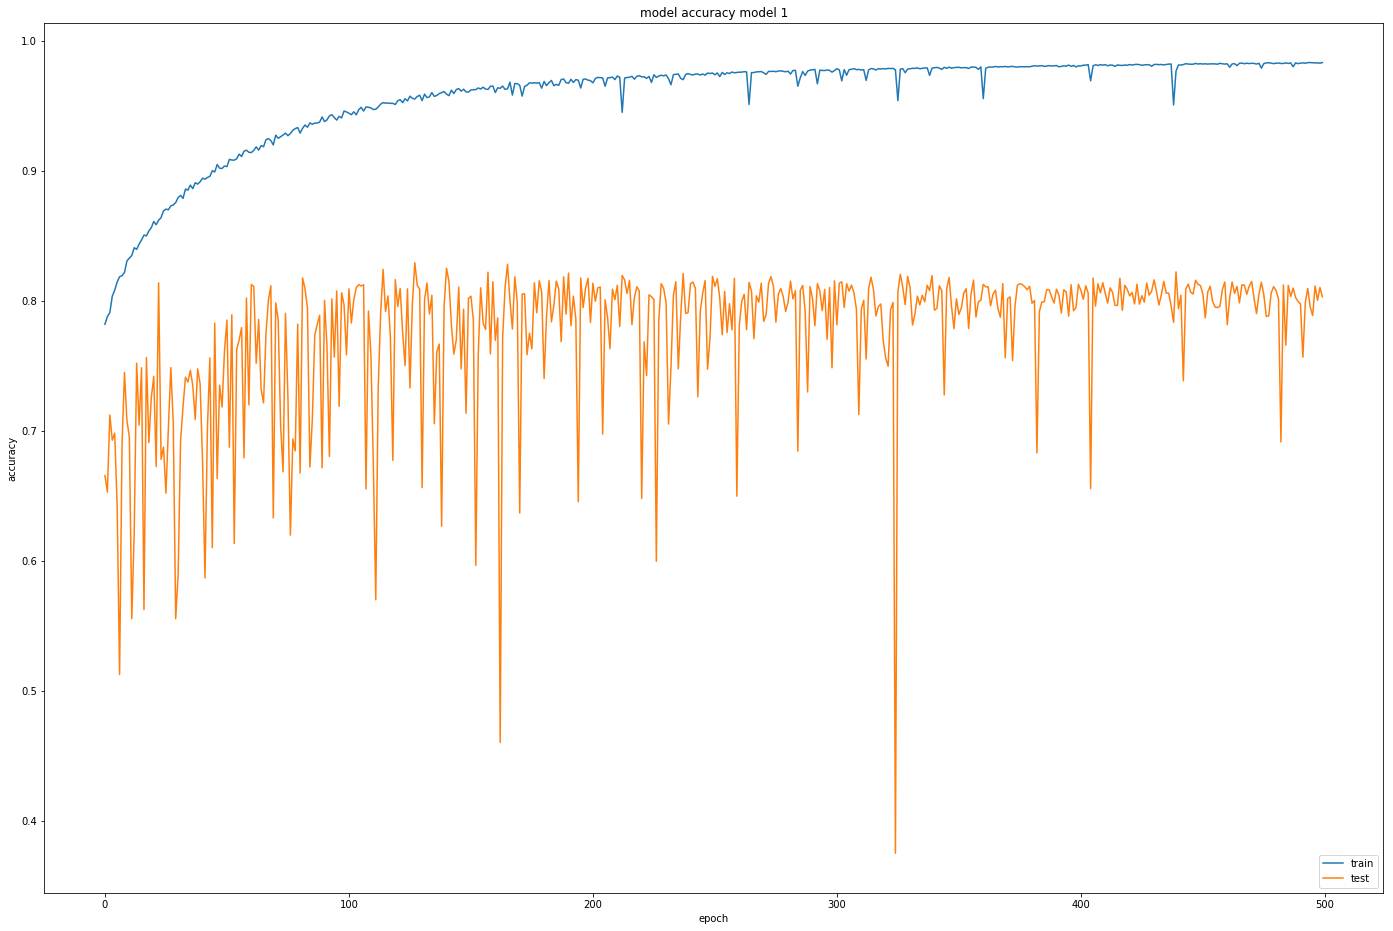

In [182]:
plt.figure(figsize=(24, 16))
 
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy model 1')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')

In [409]:
def unlabelSeg(predict):
    # Takes predicted outputs and makes a best guess at what the class would be given the probabilities
    output = predict
    for i in range(len(output[:])):
        for j in range(len(output[i,:])):
            for k in range(len(output[i, j, :])):
                m = max(output[i, j, k,:])
                output[i,j,k,:] = np.where(np.where(output[i,j,k,:] < .05, 0, output[i,j,k,:] ) == m, 1, 0)
    return output

def ConvertRGB(data, sample):
    # Used in plotting model results and input data
    # Converts the labels to their corresponding RGB color
    if len(data) == len(sample):
        output = data
    else:
        output = data[sample]
        
    Dims = len(sample)
    newArray = np.zeros((Dims,360,480,3))
    
    Sky = [128,128,128]
    Skylab = [1,0,0,0,0,0,0,0,0,0,0,0]
    Building = [128,0,0]
    Buildinglab = [0,1,0,0,0,0,0,0,0,0,0,0]
    Pole = [192,192,128]
    Polelab = [0,0,1,0,0,0,0,0,0,0,0,0]
    Road_marking = [255,69,0]
    RoadMarklab = [0,0,0,1,0,0,0,0,0,0,0,0]
    Road = [128,64,128]
    Roadlab = [0,0,0,0,1,0,0,0,0,0,0,0]
    Pavement = [60,40,222]
    Pavementlab = [0,0,0,0,0,1,0,0,0,0,0,0]
    Tree = [128,128,0]
    Treelab = [0,0,0,0,0,0,1,0,0,0,0,0]
    SignSymbol = [192,128,128]
    Signlab = [0,0,0,0,0,0,0,1,0,0,0,0]
    Fence = [64,64,128]
    Fencelab = [0,0,0,0,0,0,0,0,1,0,0,0]
    Car = [64,0,128]
    Carlab = [0,0,0,0,0,0,0,0,0,1,0,0]
    Pedestrian = [64,64,0]
    Pedestrianlab = [0,0,0,0,0,0,0,0,0,0,1,0]
    Bicyclist = [0,128,192]
    Bicyclistlab = [0,0,0,0,0,0,0,0,0,0,0,1]
    Unlabelled = [0,0,0]
    Unlab = [0,0,0,0,0,0,0,0,0,0,0,0]

    for i in range(len(output[:])):
        for j in range(len(output[i,:])):
            for k in range(len(output[i, j, :])):
                if False not in (output[i, j, k,:]== Skylab):
                    newArray[i,j,k,:] = Sky
                elif False not in (output[i,j,k,:]== Buildinglab):
                    newArray[i,j,k,:] = Building
                elif False not in (output[i,j,k,:]== Polelab):
                    newArray[i,j,k,:] = Pole
                elif False not in (output[i,j,k,:]== RoadMarklab):
                    newArray[i,j,k,:] = Road_marking
                elif False not in (output[i,j,k,:]== Roadlab):
                    newArray[i,j,k,:] = Road
                elif False not in (output[i,j,k,:]== Pavementlab):
                    newArray[i,j,k,:] = Pavement
                elif False not in (output[i,j,k,:]== Treelab):
                    newArray[i,j,k,:] = Tree
                elif False not in (output[i,j,k,:]== Signlab):
                    newArray[i,j,k,:] = SignSymbol
                elif False not in (output[i,j,k,:]== Fencelab):
                    newArray[i,j,k,:] = Fence
                elif False not in (output[i,j,k,:]== Carlab):
                    newArray[i,j,k,:] = Car
                elif False not in (output[i,j,k,:]== Pedestrianlab):
                    newArray[i,j,k,:] = Pedestrian
                elif False not in (output[i,j,k,:]== Bicyclistlab):
                    newArray[i,j,k,:] = Bicyclist
                else:
                    newArray[i,j,k,:] = Unlabelled
                    
    return newArray
                
            

In [413]:
sample = np.random.randint(0,test_data.shape[0], 4)
predict = G.predict(test_data[sample])
predict = unlabelSeg(predict)
rgbPred = ConvertRGB(predict, sample)
rgbTest = ConvertRGB(test_label, sample)

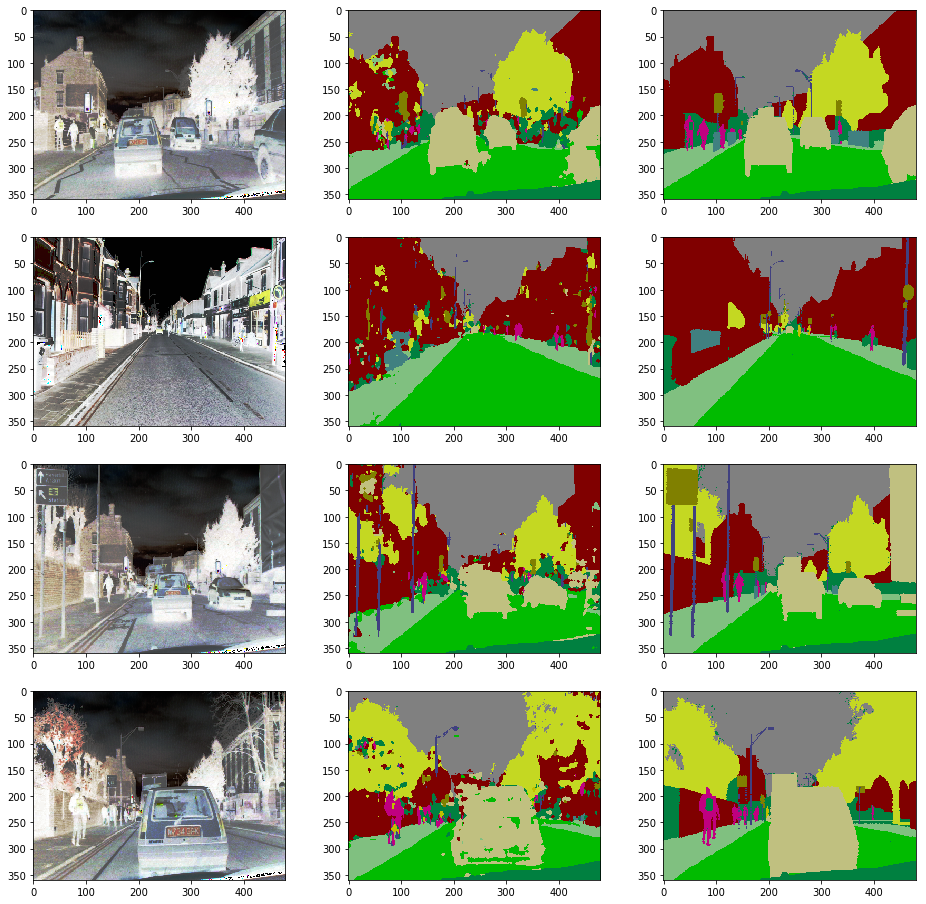

In [414]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
plt.figure(figsize=(16, 16))


plt.subplot(4,3,1)  
plt.imshow(test_data[sample][0])
plt.subplot(4,3,2)  
plt.imshow(rgbPred[0])
plt.subplot(4,3,3)  
plt.imshow(rgbTest[0])

plt.subplot(4,3,4)  
plt.imshow(test_data[sample][1])
plt.subplot(4,3,5)  
plt.imshow(rgbPred[1])
plt.subplot(4,3,6)  
plt.imshow(rgbTest[1])

plt.subplot(4,3,7)  
plt.imshow(test_data[sample][2])
plt.subplot(4,3,8)  
plt.imshow(rgbPred[2])
plt.subplot(4,3,9)  
plt.imshow(rgbTest[2])

plt.subplot(4,3,10)  
plt.imshow(test_data[sample][3])
plt.subplot(4,3,11)  
plt.imshow(rgbPred[3])
plt.subplot(4,3,12)  
plt.imshow(rgbTest[3])